# Stroke Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 3.1 Imports<a id='4.3_Imports'></a>

In [1]:
import os
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, roc_curve, precision_recall_curve
from sklearn.inspection import plot_partial_dependence

def precision_recall_plot(X: pd.DataFrame, y: pd.Series, model) -> None:
    """
    Return the precision/recall plot of the input data
    :param X:  X input as pandas dataframe
    :param y:  y input as pandas series
    :return: Plot of precision vs. recall
    """
    probs = np.array(model.predict_proba(X)[:, 1])
    precision, recall, thresh = precision_recall_curve(y, probs)
    plt.plot(thresh, precision[:-1], 'b--', label='Precision')
    plt.plot(thresh, recall[:-1], 'g--', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.show()
    
def get_classification_report(X: pd.DataFrame, y: pd.Series, model, threshold) -> None:
    """
    Return classification report of input data and threshold
    :param X:  X input as pandas dataframe
    :param y:  y input as pandas series
    :param threshold: Binary prediction threshold between (0,1)
    :return:
    """
    probs = model.predict_proba(X)[::, 1]
    predictions = np.where(probs >= threshold, 1, 0)
    print(classification_report(y, predictions))

## Load Data

In [2]:
stroke_data = pd.read_csv('../data/stroke_data_cleaned.csv')
stroke_data.head().T

,0,1,2,3,4
gender,1.00,0.000000,1.00,0.00,0.00
age,67.00,61.000000,80.00,49.00,79.00
hypertension,0.00,0.000000,0.00,0.00,1.00
heart_disease,1.00,0.000000,1.00,0.00,0.00
ever_married,1.00,1.000000,1.00,1.00,1.00
avg_glucose_level,228.69,202.210000,105.92,171.23,174.12
bmi,36.60,28.893237,32.50,34.40,24.00
smoking_status,1.00,0.000000,0.00,1.00,0.00
stroke,1.00,1.000000,1.00,1.00,1.00
residence_type,1.00,0.000000,0.00,1.00,0.00


In [3]:
stroke_data.shape

(5109, 10)

In [4]:
stroke_data.stroke.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

### Split X/Y

In [5]:
X = stroke_data.drop('stroke', axis=1)
y = stroke_data[['stroke']]

In [6]:
y.value_counts() #imbalanced dataset

stroke
0         4860
1          249
dtype: int64

# Modeling
There are 3 models that I will use here: Logistic Regression, Random Forest, and Gradient Boosting. 

## Logistic Regression

##### Fit logistic model

In [7]:
#Applying Standardization using StandardScaler().  Since we're using a logistic regression...good to use scaling.
columns = X.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=columns)
X_std.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,residence_type
0,1.189791,1.051242,-0.328637,4.184599,0.723678,2.706450,1.001041,1.433107,0.983884
1,-0.840484,0.785889,-0.328637,-0.238972,0.723678,2.121652,-0.000165,-0.697785,-1.016380
2,1.189791,1.626174,-0.328637,4.184599,0.723678,-0.004867,0.468399,-0.697785,-1.016380
3,-0.840484,0.255182,-0.328637,-0.238972,0.723678,1.437473,0.715233,1.433107,0.983884
4,-0.840484,1.581949,3.042866,-0.238972,0.723678,1.501297,-0.635858,-0.697785,-1.016380


In [8]:
#train and test split for standardized features.
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=45)

In [9]:
X_train.shape, X_test.shape 

((3576, 9), (1533, 9))

##### Fit logistic model

In [10]:
lr_std = LogisticRegression(solver='lbfgs') #had to add a solver 'lbfgs'
lr_std.fit(X_train, y_train.values.ravel()) #had to add .values.ravel() to silence warning

LogisticRegression()

##### Predict on the test set for scoring/diagnostics

In [11]:
y_pred = lr_std.predict(X_test)
y_prob = lr_std.predict_proba(X_test)[::, 1]

<AxesSubplot:>

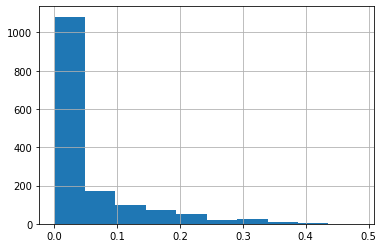

In [12]:
pd.Series(y_prob).hist(bins=10)

In [13]:
pd.Series(y_pred).value_counts() ### We're getting all 0s...since data is imbalanced.  Need to change threshold.

0    1533
dtype: int64

##### Metrics

ACU Score - Doing better than random which is 0.5...so the model is learning

In [14]:
print(roc_auc_score(y_test, y_prob)) # Make sure to use the probability instead of the prediction value

0.8449802964908989


Precision/Recall Plot - Let's find that ideal threshold number

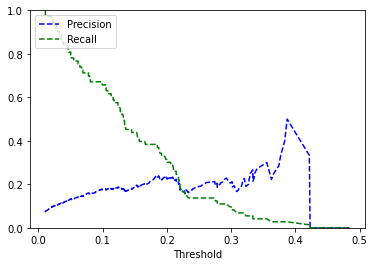

<Figure size 432x288 with 0 Axes>

In [15]:
precision_recall_plot(X_test, y_test, lr_std)
plt.savefig("prec-recall-logistic-regression.png")

Classification report - Let's see how well we're doing with precision and recall for stroke/non-stroke

In [16]:
get_classification_report(X_test, y_test, lr_std, threshold=0.35)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1460
           1       0.30      0.04      0.07        73

    accuracy                           0.95      1533
   macro avg       0.63      0.52      0.52      1533
weighted avg       0.92      0.95      0.93      1533



**Maybe we set the threshold to around 0.35??? since we're doing well at being precise for stroke cases**

In [17]:
#Logistic Regression - Accuracy Score
Accuracy_lr = accuracy_score(y_test, y_pred)
print('Accuracy score: ' +str(Accuracy_lr))

Accuracy score: 0.9523809523809523


In [18]:
#Logistic Regression - Cross Validation Score
cv_scores_test= cross_val_score(lr_std, X_test, y_test.values.ravel(), cv=5, scoring='roc_auc')
cv_scores_train= cross_val_score(lr_std, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.76826484 0.8390411  0.85251142 0.90680039 0.83928571]
Mean cross validation test score: 0.841180691454664
Mean cross validation train score: 0.8387682072829131
Standard deviation in cv test scores: 0.044179679722383326


## Random Forest

##### Preprocessing the data 
We don't want scaled since doing a tree based model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

##### Fit the model
Doing a grid search this time since random forests have a lot of parameters to tune

In [20]:
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 3, 4],
    'criterion' :['gini', 'entropy']
}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)

In [21]:
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100]})

In [22]:
best_rfc = grid_search.best_estimator_
best_rfc # Getting the best model out of the set of models that were searched

RandomForestClassifier(max_depth=2, n_estimators=50, random_state=42)

##### Predict on the test set for scoring/diagnostics

In [23]:
y_pred = best_rfc.predict(X_test)
y_prob = best_rfc.predict_proba(X_test)[::, 1]

<AxesSubplot:>

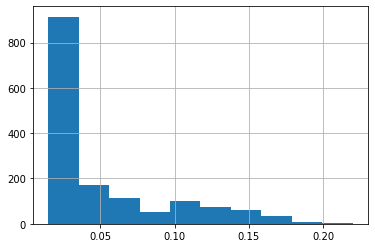

In [24]:
pd.Series(y_prob).hist(bins=10)

In [25]:
pd.Series(y_pred).value_counts() ### We're getting all 0s...since data is imbalanced.  Need to change threshold.

0    1533
dtype: int64

##### Metrics

ACU Score - Model still learned!

In [26]:
print(roc_auc_score(y_test, y_prob)) # Make sure to use the probability instead of the prediction value

0.8385485081628823


Precision/Recall Plot - Let's find that ideal threshold number

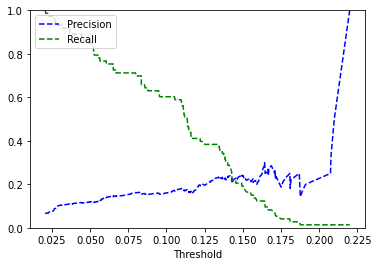

<Figure size 432x288 with 0 Axes>

In [27]:
precision_recall_plot(X_test, y_test, best_rfc)
plt.savefig("prec-recall-random-forest.png")

Classification report - Let's see how well we're doing with precision and recall for stroke/non-stroke

In [28]:
get_classification_report(X_test, y_test, best_rfc, threshold=0.11)

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1460
           1       0.18      0.56      0.27        73

    accuracy                           0.86      1533
   macro avg       0.58      0.72      0.59      1533
weighted avg       0.94      0.86      0.89      1533



**Maybe we set the threshold to around 0.12??? since we're doing well at being precise for stroke cases**

##### Model Explanation
Let's start to understand what is being learned by the model

Feature importance - This will show us which variable have the greatest impact (not necessarily direction)
to prediction stroke/not

In [29]:
rfc_feature_importance = pd.Series(best_rfc.feature_importances_, index=X.columns)

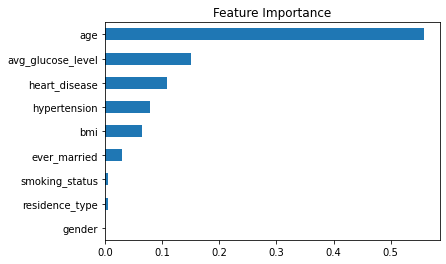

In [30]:
rfc_feature_importance.nlargest(10).sort_values(ascending=True).plot.barh()
plt.title('Feature Importance')
plt.savefig("feat-importance-random-forest.png")

Partial Dependence - This will show us direction and when we'd expect increases in stroke likelihood for a given
variable

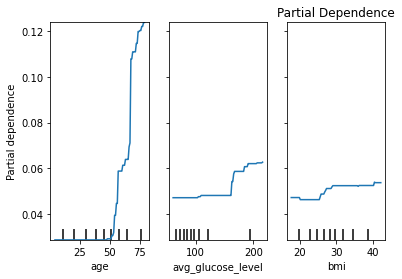

In [31]:
plot_partial_dependence(best_rfc, X_test, features=['age', 'avg_glucose_level', 'bmi'])
plt.title('Partial Dependence')
plt.savefig("partial-dependence-random-forest.png")

In [32]:
#Random Forest - Accuracy Score
Accuracy_rfc = best_rfc.score(X_test,y_test)
print('Accuracy score: ' +str(Accuracy_rfc))

Accuracy score: 0.9523809523809523


In [33]:
#Random Forest - Cross Validation Score
cv_scores_test= cross_val_score(best_rfc, X_test, y_test.values.ravel(), cv=5, scoring='roc_auc')
cv_scores_train= cross_val_score(best_rfc, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
print(cv_scores_test)
cv_scores_rfc_test= cv_scores_test.mean()
cv_scores_rfc_train= cv_scores_train.mean()
cv_scores_std_test_rfc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rfc_test))
print ('Mean cross validation train score: ' +str(cv_scores_rfc_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_rfc))

[0.71038813 0.82477169 0.86518265 0.90203033 0.83390411]
Mean cross validation test score: 0.8272553816046967
Mean cross validation train score: 0.8423487394957985
Standard deviation in cv test scores: 0.06440201888872178


## Gradient Boosting 

##### Fit the model
Doing GridSearch again for Gradient Boosting.

In [34]:
gbc = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth' : [2, 3, 4, 5, 6]
}
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3)

In [35]:
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [50, 100]})

In [36]:
best_gbc = grid_search.best_estimator_
best_gbc

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=50)

##### Predict on the test set for scoring/diagnostics

In [37]:
y_pred = best_gbc.predict(X_test)
y_prob = best_gbc.predict_proba(X_test)[::, 1]

<AxesSubplot:>

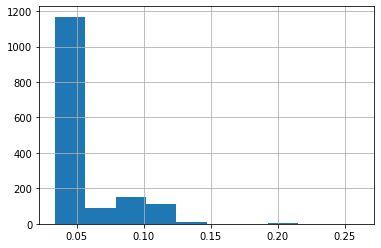

In [38]:
pd.Series(y_prob).hist(bins=10)

In [39]:
pd.Series(y_pred).value_counts()

0    1533
dtype: int64

##### Metrics
AUC Score - did model learn?

In [40]:
print(roc_auc_score(y_test, y_prob)) #not as good as random forest

0.8309908050290861


Precision/Recall Plot - Ideal threshold number for Gradient Boosting?

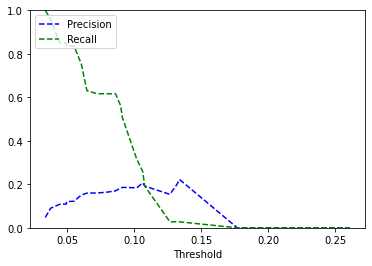

<Figure size 432x288 with 0 Axes>

In [41]:
precision_recall_plot(X_test, y_test, best_gbc)
plt.savefig("prec-recall-gradient-boost.png")

Classification report - Let's see how well we're doing with precision and recall for stroke/non-stroke

In [42]:
get_classification_report(X_test, y_test, best_gbc, threshold=0.06)

              precision    recall  f1-score   support

           0       0.98      0.79      0.88      1460
           1       0.15      0.75      0.25        73

    accuracy                           0.79      1533
   macro avg       0.57      0.77      0.56      1533
weighted avg       0.94      0.79      0.85      1533



In [43]:
get_classification_report(X_test, y_test, best_gbc, threshold=0.12)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1460
           1       0.15      0.03      0.05        73

    accuracy                           0.95      1533
   macro avg       0.55      0.51      0.51      1533
weighted avg       0.92      0.95      0.93      1533



Maybe set threshold to 0.06 since recall is better for that range of number.

##### Model Explanation
Feature Importance & Partial Dependence Plots

In [44]:
gbc_feature_importance = pd.Series(best_gbc.feature_importances_, index=X.columns)

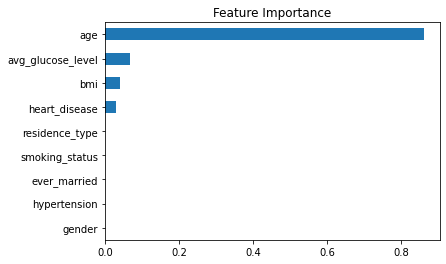

In [45]:
gbc_feature_importance.nlargest(10).sort_values(ascending=True).plot.barh()
plt.title('Feature Importance')
plt.savefig("feat-importance-gradient-boost.png")

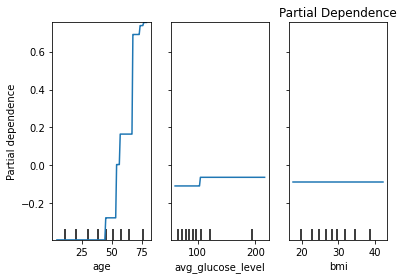

In [46]:
plot_partial_dependence(best_gbc, X_test, features=['age', 'avg_glucose_level', 'bmi'])
plt.title('Partial Dependence')
plt.savefig("partial-dependence-gradient-boost.png")

In [47]:
#Gradient Boosting - Accuracy Score
Accuracy_gbc = best_gbc.score(X_test,y_test)
print('Accuracy score: ' +str(Accuracy_gbc))

Accuracy score: 0.9523809523809523


In [48]:
#Gradient Boosting - Cross Validation Score
cv_scores_test= cross_val_score(best_gbc, X_test, y_test.values.ravel(), cv=5, scoring='roc_auc')
cv_scores_train= cross_val_score(best_gbc, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_test_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_gbc))

[0.70308219 0.7880137  0.75388128 0.90264188 0.83671722]
Mean cross validation test score: 0.7968672537508154
Mean cross validation train score: 0.8182607376283848
Standard deviation in cv test scores: 0.06855378695459682


## Compare the models and draw insights
What variable have and impact (in-depth on the columns)

We applied different ML models above and evaluated their performances in terms of ROC-AUC score for both the training and test data. Here we have tabulated the scores and plotted them.
Clearly, the Logistic Regression, and the Random Forest are the two best performing models. Both of the models are ensembled, based on decision trees.
So, we will perform a grid search/ hyperparameter tuning for those two ML models.

In [49]:
myLabels = ['Logistic Regression', 'Random Forest', 'Gradient Boost']
score_test= [cv_scores_lr_test, cv_scores_rfc_test, cv_scores_gbc_test]
score_train= [ cv_scores_lr_train, cv_scores_rfc_train, cv_scores_gbc_train]
Accuracy_score = [Accuracy_lr, Accuracy_rfc, Accuracy_gbc]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

score_tab 

             Algorithm  Model accuracy score
0  Logistic Regression              0.952381
1        Random Forest              0.952381
2       Gradient Boost              0.952381


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Logistic Regression,0.838768,0.841181
1,Random Forest,0.842349,0.827255
2,Gradient Boost,0.818261,0.796867


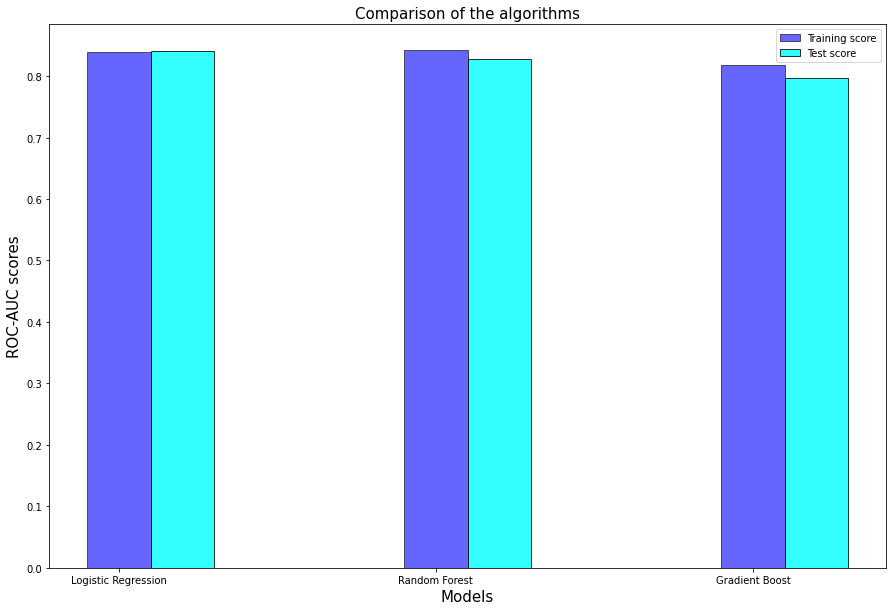

In [50]:
#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(15,10))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)

_ = plt.bar(index,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_ = plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1,2,3], myLabels)
plt.legend()
plt.savefig("comparison-of-algorithms.png")
plt.show()

Here we see that Random Forest has the best ROC_AUC scores for the training. Logistic Regression, however, has the best scores for testing.

## Conclusion and Process

I started with the dataset from Kaggle, which was already pretty clean to be honest. There were 5110 observations and 12 attributes, which I did end up dropping 3 of the columns (‘id’, ’Residence_type’, and ‘work_type’) because they were not important factors of stroke or stress, and couldn’t be quantified anyway.  I did find that the ‘bmi’ column had 201 counts of missing values, about 3.9%. I filled the missing values with the mean of the column because BMI is an important factor of a person’s physique, and an important factor of obesity. I did also have to deal with some categorical features of the dataset such as gender, ever-married, smoking_status. I thought it was important to translate those categorical features to numerical features, so I did that. For instance with gender, Females became 0, and Males became 1.

It was at this point in my project that I started to do lots of research about what factors make up a stroke, and I copied them from the Mayo Clinic onto my jupyter notebook so that I could compare them to the attributes that I had in my dataset. After this I plotted different attributes to get some visualization on my data. This is when I found out that my data had age ranges from 0 to 80 years old! This was a very interesting part of my EDA exploratory data analysis. The correlation heatmap showed that there was higher correlation between ‘age’ and ‘ever_married’.

In my preprocessing/training and modeling part of my project I started to split the data into X equaling the dataset without the stroke column, and y equaling the stroke column. I then decided I would use three different models for this project: Logistic Regression, Random Forest, and Gradient Boosting. For each of the models I fit the model, and looked at the shape. I then predicted on the test set for scoring and diagnostics. The threshold for each model was going to have to be figured out, so a precision recall plot was the best way to visualize the best threshold. It was also important to plot the feature importance in each model so see when we’d expect increases in stroke likelihood for a given variable. Age was by far the most important variable and that also ran true when I used a partial dependence plot. The likelihood of stroke after age 50, shot nearly straight up. What I found was Logistic Regression and Random Forest were the two best performing models. 

Comparing the performance of LR and RF. Logistic Regression had a ROC-AUC train score of 83.87% and a ROC-AUC test score of 84.11%. Random Forest had a ROC-AUC train score of 84.23% and a ROC-AUC test score of 82.72%. 

Logistic Regression is the best model for my stroke prediction capstone, although Random Forest is a very close second. Random Forest tended to overfit on the training set. But all in all a simple model worked better on this dataset because it was so small (only 5000 patients). I did try hyperparameter tuning on the Random Forest model, but it didn’t seem to do any better and took a long time to run. I would have liked to add more data, especially on patients that were diagnosed to have already had a stroke. As it stood my dataset only had about 4.9% of the patients did already have a stroke.